In [1]:
import torch
import torch.nn as nn
# from generate_data import *
import matplotlib.pyplot as plt
import numpy as np
import math
from load_matlab_timedata import get_data_from
import sklearn.preprocessing 

In [2]:
! ls DC_motor_simulation

DC_motor_simulation.prj      diff_eq_system.slxc	  res2.mat   slprj
diff_eq_system.slx	     diff_eq_system.slx.original  res.mat
diff_eq_system.slx.autosave  in.mat			  resources


In [117]:
data = get_data_from('DC_motor_simulation/res.mat')

<KeysViewHDF5 ['ans']>


In [118]:
num_datapoints = 400

In [132]:
time, x, y = data[:num_datapoints, 0], data[:num_datapoints, 1], data[:num_datapoints, 2]

In [133]:
num_datapoints = time.shape[0]
num_datapoints

400

In [134]:
try_sin = False
if try_sin:
    T = [ t for t in np.arange(0, math.pi * 10, math.pi / 100)]
    T = T[:num_datapoints]
    sin_t = [math.sin(t) for t in T]
    plt.plot(sin_t)
    x = np.array(T)
    y = np.array(sin_t)

In [135]:
x

array([ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12

In [136]:
x

array([ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12

In [137]:
x_normalized, x_norms = sklearn.preprocessing.normalize(x.reshape(-1,1),
                                                  axis = 0,
                                                  norm = 'max',
                                                  return_norm = True)
y_normalized, y_norms = sklearn.preprocessing.normalize(y.reshape(-1,1),
                                                  axis = 0,
                                                  norm = 'max', 
                                                  return_norm = True)

In [138]:
x = x_normalized
y = y_normalized

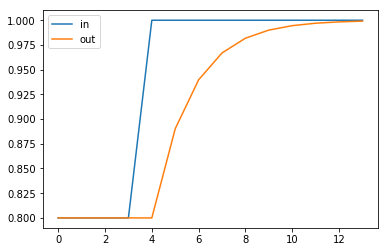

In [141]:
plt.plot(x[num_datapoints//6:num_datapoints//5], label = "in")
plt.plot(y[num_datapoints//6:num_datapoints//5], label = "out")
plt.legend()

Example of generating SIN wave of same len to werify model validity

In [142]:
x = np.repeat(x,20, axis = 0)
y = y
# x = np.repeat(T,20, axis = 0)
# y = np.array(sin_t)

In [143]:
x.shape

(8000, 1)

In [144]:
x = x.reshape([num_datapoints, -1])
y = y.reshape([num_datapoints, -1])

In [145]:
x.shape

(400, 20)

In [146]:
#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = num_datapoints
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

# Network params
input_size = 20
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 128
output_dim = 1
num_layers = 2
learning_rate = 1e-3
num_epochs = 5000
dtype = torch.float


In [147]:
generate_data = False
#####################
# Generate data
#####################
if generate_data:
    data = ARData(num_datapoints,
                  num_prev=input_size,
                  test_size=test_size, 
                  noise_var=noise_var,
                  coeffs=fixed_ar_coefficients[input_size])

    # make training and test sets in torch
    X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
    X_test = torch.from_numpy(data.X_test).type(torch.Tensor)
    y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
    y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)

    X_train = X_train.view([input_size, -1, 1])
    X_test = X_test.view([input_size, -1, 1])

In [148]:
X_train = torch.from_numpy(x[:num_train, :].T).type(torch.Tensor)
X_test = torch.from_numpy(x[num_train:, :].T).type(torch.Tensor)
X_train = X_train.view([input_size, -1, 1])
X_test = X_test.view([input_size, -1, 1])
y_train = torch.from_numpy(y[:num_train, :]).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y[num_train:, :]).type(torch.Tensor).view(-1)

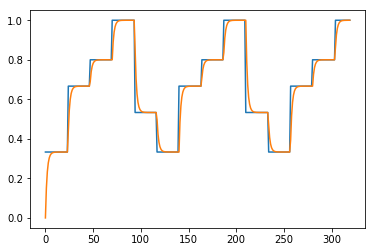

In [150]:
plt.plot(X_train.detach().numpy()[0, :num_datapoints])
plt.plot(y_train.detach().numpy()[ :num_datapoints])

In [151]:

#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


/home/dkushn/miniconda3/envs/dkushn_dyploma/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch  0 MSE:  152.69442749023438


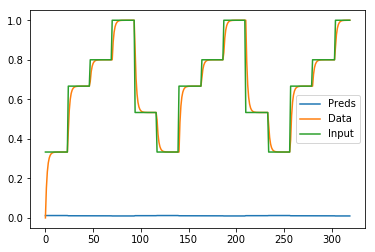

Epoch  100 MSE:  1.2845226526260376


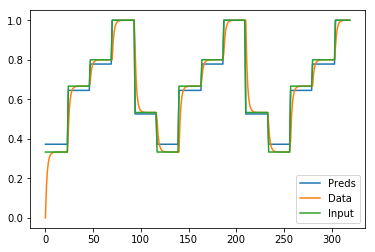

Epoch  200 MSE:  1.1559088230133057


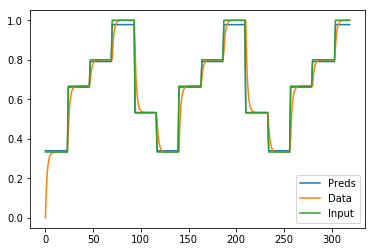

Epoch  300 MSE:  1.1532552242279053


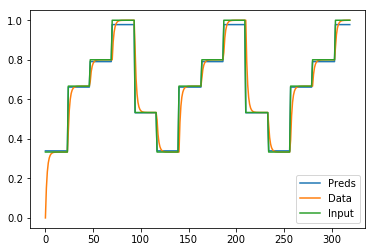

Epoch  400 MSE:  1.1494098901748657


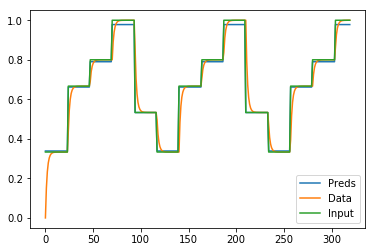

Epoch  500 MSE:  1.143520712852478


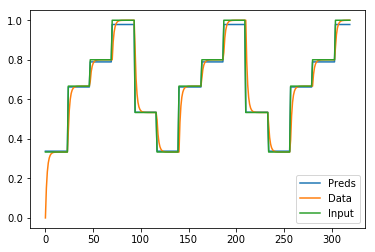

Epoch  600 MSE:  1.1339185237884521


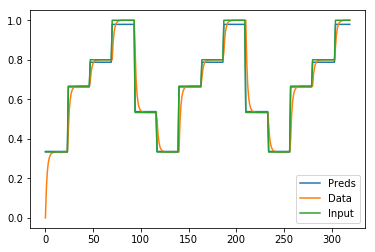

Epoch  700 MSE:  1.1190739870071411


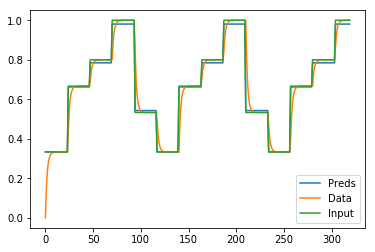

Epoch  800 MSE:  1.1044950485229492


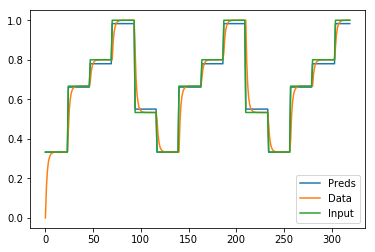

Epoch  900 MSE:  1.1055854558944702


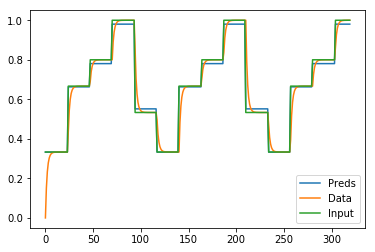

Epoch  1000 MSE:  1.1007901430130005


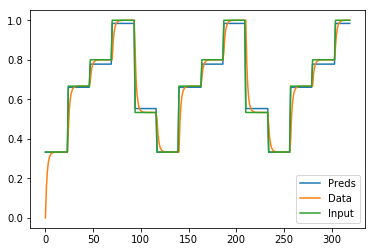

Epoch  1100 MSE:  1.6524322032928467


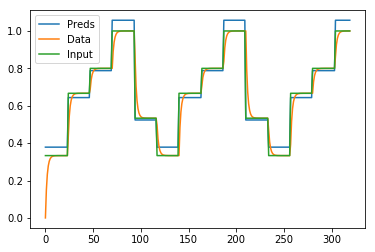

Epoch  1200 MSE:  1.1492455005645752


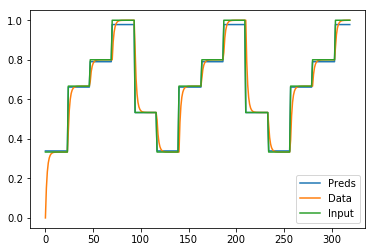

Epoch  1300 MSE:  1.1445199251174927


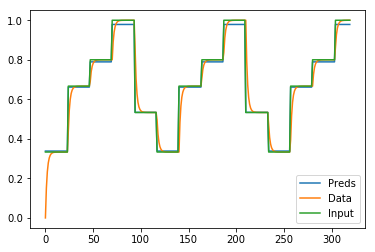

Epoch  1400 MSE:  1.138741374015808


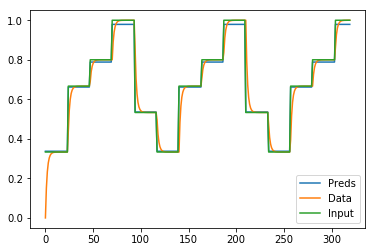

In [ ]:
#####################
# Train model
#####################

hist = np.zeros(num_epochs)

model.hidden = model.init_hidden()
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
        
        plt.plot(y_pred[:].detach().numpy(), label="Preds")
        plt.plot(y_train[:].detach().numpy(), label="Data")
        plt.plot(X_train[0][:].detach().numpy(), label="Input")
        
        plt.legend()
        plt.show()
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


In [ ]:

#####################
# Plot preds and performance
#####################
plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()
plt.plot(X_train[0, :, -1].detach().numpy(), label="ARG")